In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Hack pro GPU na Windows
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

### Načteme data

In [160]:
import numpy as np
import os

PATH = os.path.join("datasets", "09", "jena")

In [244]:
import pandas as pd

def load_data(file, path=PATH):
    csv = os.path.join(path, file)
    return pd.read_csv(csv)

In [245]:
data = pd.read_csv('/content/jena_climate_2009_2016.csv')
data.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [246]:
train_index = 200000 # 0 - 200000 trénovací
valid_index = 300000 # 200001 - 300000 validační
                     # zbytek testovací

**Nyní potřebujeme nachystat trénovací data**

Trénovací data chceme mít např. v této podobě: 
- features: údaje za X dní zpátky od zvoleného bodu
- label: údaj za 24 hodin do budoucna od zvoleného bodu

Protože by bylo velmi neúsporné chystat takto postupně všechny posloupnosti dat, nachystáme si na to generátor, který bude trénovací data vytvářet za běhu.  

* `data`
* `lookback`: kolik časových kroků zpátky chceme jít
* `future`: kolik časových kroků do budoucna má být label
* `min_index`, `max_index`: v jaké oblasti dat se chceme pohybovat (důležité, abychom nedostali testovací data do trénovacích)
* `shuffle`: jestli se mají data vybírat náhodně z definované oblasti
* `batch_size`
* `step`: po kolika krocích vybírat data. 6 = 6x10 minut = hodina

In [247]:
lookback = 1440 # 10 dní zpátky 
step = 6  # po kolika krocích vybírat časové body
future = 6*24 # 6 x 24 = 24 hodin dopředu
batch_size = 128 
timesteps_in_instance = int(lookback / step)

In [357]:
def generator(data, lookback, future, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - future - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),2))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + future][:2]
            
        yield samples, targets

### Můžeme ještě vyzkoušet pracovat s periodicitou

V případě časové řady s počasím se nabízí roční a denní periodicita

In [249]:
import time
import datetime

timestamps = pd.to_datetime(data['Date Time'], format='%d.%m.%Y %H:%M:%S').map(datetime.datetime.timestamp)

In [250]:
day = 24*60*60
year = (364.2425)*day

data['Day sin'] = np.sin(timestamps * (2 * np.pi / day))
data['Day cos'] = np.cos(timestamps * (2 * np.pi / day))
data['Year sin'] = np.sin(timestamps * (2 * np.pi / year))
data['Year cos'] = np.cos(timestamps * (2 * np.pi / year))

In [251]:
data.drop(columns=['Date Time'], inplace=True)

In [252]:
np_data = data.to_numpy()

In [253]:
train_steps = (train_index - lookback) // batch_size
valid_steps = (valid_index - train_index - lookback -1) // batch_size
test_steps = (len(np_data) - valid_index - lookback -1) // batch_size

In [254]:
# scaling
mean = np_data[:train_index].mean(axis=0)
np_data -= mean
std = np_data[:train_index].std(axis=0)
np_data /= std

In [255]:
train_gen = generator(np_data,
                      lookback=lookback,
                      future=future,
                      min_index=0,
                      max_index=train_index,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

valid_gen = generator(np_data,
                    lookback=lookback,
                    future=future,
                    min_index=train_index+1,
                    max_index=valid_index,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(np_data,
                     lookback=lookback,
                     future=future,
                     min_index=valid_index+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [256]:
(X, y) = next(train_gen)

In [257]:
X.shape

(128, 240, 18)

In [258]:
y.shape

(128, 2)

In [259]:
np_data.shape

(420551, 18)

In [260]:
timesteps_in_instance

240

In [261]:
model = keras.models.Sequential([
    layers.GRU(32, return_sequences=True, input_shape=(timesteps_in_instance, np_data.shape[1])),
    # layers.GRU(32),
    layers.Flatten(),
    layers.Dense(2),
])

In [262]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae')

In [263]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/09_timeseries_gru_multi_period.keras', save_best_only=True, monitor='val_loss')

In [264]:
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=valid_steps,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/10
1551/1551 [==============================] - 78s 49ms/step - loss: 0.4237 - val_loss: 0.4239
Epoch 2/10
1551/1551 [==============================] - 76s 49ms/step - loss: 0.3806 - val_loss: 0.4181
Epoch 3/10
1551/1551 [==============================] - 75s 49ms/step - loss: 0.3619 - val_loss: 0.4144
Epoch 4/10
1551/1551 [==============================] - 76s 49ms/step - loss: 0.3485 - val_loss: 0.4238
Epoch 5/10
1551/1551 [==============================] - 76s 49ms/step - loss: 0.3390 - val_loss: 0.4256
Epoch 6/10
1551/1551 [==============================] - 76s 49ms/step - loss: 0.3295 - val_loss: 0.4283


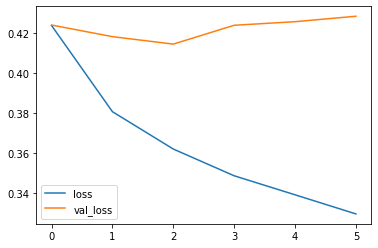

In [265]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [266]:
np.min(history.history['val_loss'])

0.4143916964530945

In [267]:
model = keras.models.load_model('/content/09_timeseries_gru_multi_period.keras')

In [268]:
model.evaluate(test_gen, steps=test_steps)

930/930 [==============================] - 18s 19ms/step - loss: 0.4329


0.4329393804073334

# Predikce pro jednu dávku

In [269]:
(one_X, one_y) = next(test_gen)

In [276]:
res = model.predict(one_X)

In [313]:
res.shape

(128, 2)

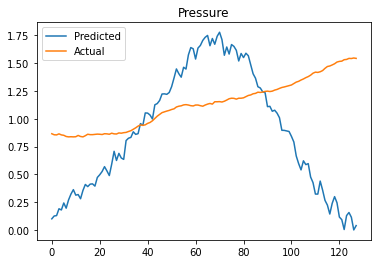

In [317]:
pd.DataFrame(np.vstack((res[:,0], one_y[:,0]))).T.rename({0:'Predicted', 1:'Actual'}, axis=1).plot(title='Pressure')

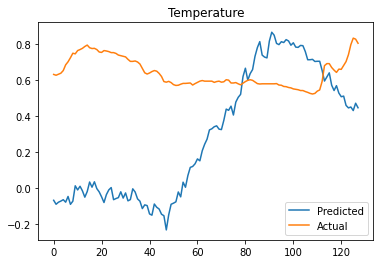

In [308]:
pd.DataFrame(np.vstack((res[:,1], one_y[:,1]))).T.rename({0:'Predicted', 1:'Actual'}, axis=1).plot(title='Temperature')

# Sekvence

In [407]:
lookback = 1440 # 10 dní zpátky 
step = 6  # po kolika krocích vybírat časové body
future = 6 # 6 x 24 = 24 hodin dopředu
batch_size = 128 
timesteps_in_instance = int(lookback / step)

In [408]:
train_steps = (train_index - lookback) // batch_size
valid_steps = (valid_index - train_index - lookback -1) // batch_size
test_steps = (len(np_data) - valid_index - lookback -1) // batch_size

In [409]:
train_gen = generator(np_data,
                      lookback=lookback,
                      future=future,
                      min_index=0,
                      max_index=train_index,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)

valid_gen = generator(np_data,
                    lookback=lookback,
                    future=future,
                    min_index=train_index+1,
                    max_index=valid_index,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(np_data,
                     lookback=lookback,
                     future=future,
                     min_index=valid_index+1,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [410]:
model = keras.models.Sequential([
    layers.GRU(32, return_sequences=True, input_shape=(timesteps_in_instance, np_data.shape[1])),
    layers.Flatten(),
    layers.Dense(2*24),
    layers.Reshape([24, 2])
])

In [411]:
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_29 (GRU)                (None, 240, 32)           4992      
                                                                 
 flatten_14 (Flatten)        (None, 7680)              0         
                                                                 
 dense_28 (Dense)            (None, 48)                368688    
                                                                 
 reshape_9 (Reshape)         (None, 24, 2)             0         
                                                                 
Total params: 373,680
Trainable params: 373,680
Non-trainable params: 0
_________________________________________________________________


In [412]:
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), loss='mae')

In [413]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
checkpoint = keras.callbacks.ModelCheckpoint(filepath='/content/09_timeseries_gru_multi_period.keras', save_best_only=True, monitor='val_loss')

In [414]:
history = model.fit(train_gen,
                    steps_per_epoch=train_steps,
                    epochs=10,
                    validation_data=valid_gen,
                    validation_steps=valid_steps,
                    callbacks=[early_stopping, checkpoint])

Epoch 1/10


InvalidArgumentError: ignored

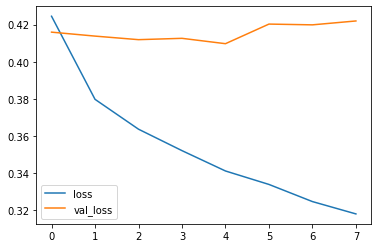

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()

In [ ]:
np.min(history.history['val_loss'])

0.4097098410129547

In [ ]:
model = keras.models.load_model('/content/09_timeseries_gru_multi_period.keras')

In [ ]:
model.evaluate(test_gen, steps=test_steps)

930/930 [==============================] - 19s 19ms/step - loss: 0.4284


0.4284306764602661